# Import libraries, Load Data

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
import seaborn as sns
import yfinance as yf
from numpy import linalg as LA
from sklearn.cluster import KMeans
from statsmodels.tsa.stattools import coint
from itertools import combinations
import matplotlib.dates as mdates
from datetime import datetime


In [4]:
price_path = '/Users/tuckeringlefield/Desktop/FinanceData/price_data_from_shardar.csv'
cap_path = '/Users/tuckeringlefield/Desktop/FinanceData/cap_data_from_shardar.csv'
#price_path = "C:/Users/lukee/Downloads/price_data_from_shardar.csv"
#cap_path = "C:/Users/lukee/Downloads/cap_data_from_shardar.csv"
prices_df = pd.read_csv(price_path, index_col='date')
caps_df = pd.read_csv(cap_path, index_col='date')
# Drop troubled stock
prices_df.drop(["MGI", "MDLZ", "DWA", "ICE"], axis=1, inplace=True)
caps_df.drop(["MGI", "MDLZ", "DWA", "ICE"], axis=1, inplace=True)

In [5]:
# Convert dates to datetime
prices_df.index = pd.to_datetime(prices_df.index)

# Get the initial start and end date
start_date = prices_df.index[0]
end_date = prices_df.index[-1]

spy_data = yf.download('SPY', start=start_date, end=end_date, interval='1d')
spy_data = pd.DataFrame(spy_data["Adj Close"])
spy_data.rename({"Adj Close": 'SPY'}, inplace=True, axis=1)
prices_with_market = prices_df.merge(spy_data, how='left', left_index=True, right_index=True)

df_diff = prices_with_market.diff().dropna()

[*********************100%%**********************]  1 of 1 completed


# Outline and Function Definitions

### Functions

In [8]:
# Function to find the top ten largest market cap stocks
def find_top_ten(dataframe, date_start, date_end):
    # Filter dataframe over the desired 3 months
    # filtered_data = dataframe[date_start:date_end]
    target_date = date_end + 1
    selected_row = caps_df.iloc[target_date]
    selected_row_no_null = selected_row.dropna()
    stocks_list = selected_row_no_null.nlargest(10).index.tolist()
    return stocks_list

In [9]:
# Function to check for null values
def check_top_ten(dataframe, date_start, date_end, stocks_list):
    #should find the average and median ammount of null values per column
    #print this out and print out top ten col's ammounts
    ammount_null = []
    for column in df.columns:
        num_null = df[column].isnull().sum()
        ammount_null.append(num_null)
    average_num_null = np.mean(ammount_null)
    median_num_null = np.median(ammount_null)
    plt.boxplot(ammount_null, vert=False)
    plt.title('Boxplot of null values per stock in time period')
    plt.show()
    print("Checking Stocks List")
    print("--------------------")
    for column in stocks_list:
        num_null = df[column].isnull().sum()
        print(f'Stock: {column}, Num null: {num_null}')

In [10]:
# Function to filter the DF
def filter_diff_df(dataframe, date_start, date_end, stocks_list):
    desired_columns = stocks_list.copy()
    desired_columns.append("SPY")
    #print(desired_columns)
    filtered_df = dataframe[desired_columns]
    filtered_df = filtered_df[date_start:date_end].diff()#.dropna()
    # print("Filtered diff df len (before dropna):", len(filtered_df))
    # print(filtered_df.head())
    # print(len(filtered_df))
    # print(filtered_df.isnull().sum())
    filtered_df = filtered_df.dropna()
    # print("Filtered diff df len (after dropna):", len(filtered_df))
    # print(len(filtered_df))
    return filtered_df

In [11]:
def filter_df_by_dates(dataframe, date_start, date_end, stocks_list):
    desired_columns = stocks_list.copy()
    desired_columns.append("SPY")
    filtered_df = dataframe[desired_columns]
    filtered_df = filtered_df[date_start:date_end]
    return filtered_df

In [12]:
# Function to calculate the betas
def calculate_betas(dataframe, date_start, date_end, stocks_list):
    # df = dataframe[date_start:date_end]
    beta_values = []
    columns = []

    df_var = dataframe['SPY'].var()

    for stk in stocks_list:
        df_cov = dataframe[[stk, 'SPY']].cov().loc[stk, 'SPY']
        beta = df_cov / df_var
        beta_values.append(beta)
        columns.append(stk + '_beta')

    beta_df = pd.DataFrame([beta_values], columns=columns)
    beta_df.index = dataframe.index[:1]

    # plt.figure(figsize=(12, 4))
    # sns.boxplot(data=beta_df)
    # plt.show()

    return beta_df

In [13]:
# Function to calculate the residuals
def calculate_residuals(df, stocks_list):
    res_df = pd.DataFrame()
    for stk in stocks_list:
        res_df[stk] = df[stk]-df[stk+"_beta"]*df["SPY"]
    return res_df

In [14]:
# Function to cluster the matrix
def cluster_the_matrix(df, num_clusters):
    A = abs(df.corr().values)
    #print(f'A Shape: {A.shape}')
    D = np.diag(A.sum(axis=1))
    #print(f'D Shape: {D.shape}')
    L = D - A
    #print(f'L Shape: {L.shape}')
    eigenvalues, eigenvectors = LA.eig(L)
    X = eigenvectors[:,:num_clusters]
    #print(f'X Shape: {X.shape}')
    kmeans = KMeans(n_clusters=num_clusters, random_state=2, n_init=20).fit(X)
    #print("Kmeans Labels:")
    #print(kmeans.labels_)
    #print(df.columns)

    cluster_dict = {}

    # Iterate over the indices of cluster_list
    for i in range(len(kmeans.labels_)):
        cluster_number = kmeans.labels_[i]
        stock_name = df.columns[i]

        # Check if cluster_number is already a key in the dictionary
        if cluster_number in cluster_dict:
            cluster_dict[cluster_number].append(stock_name)
        else:
            cluster_dict[cluster_number] = [stock_name]

    # fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    # scatter = ax.scatter(X[:, 0], X[:, 1], c=kmeans.labels_)
    # unique_labels = {label: idx for idx, label in enumerate(set(kmeans.labels_))}
    # handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(value)), markersize=10)
    #        for value in unique_labels.values()]
    # labels = unique_labels.keys()
    # ax.legend(handles, labels, title="Clusters", loc="best", bbox_to_anchor=(1, 1))
    # ax.set_title(f'K-Means Clustering Results with K={num_clusters}')
    # plt.show()

    return cluster_dict


In [15]:
# Function to find the cointegrated pairs
def find_cointegrated_pairs(dataframe, cluster_dict, sig_level):
    cointegrated_pairs = []
    for cluster_num, stocks in cluster_dict.items():
      for stock1, stock2 in combinations(stocks, 2):
          pvalue1 = coint(dataframe[stock1], dataframe[stock2])[1]
          pvalue2 = coint(dataframe[stock2], dataframe[stock1])[1]
          if pvalue1 < sig_level and pvalue2 < sig_level:
              cointegrated_pairs.append((stock1, stock2))
    return cointegrated_pairs

In [16]:
# Function to check on existing pairs
def is_still_conintegrated(dataframe, pair, sig_level):
    stock1 = pair[0]
    stock2 = pair[1]
    pvalue1 = coint(dataframe[stock1], dataframe[stock2])[1]
    pvalue2 = coint(dataframe[stock2], dataframe[stock1])[1]
    if pvalue1 < sig_level and pvalue2 < sig_level:
        return True
    return False

In [17]:
# weekly function to calculate the beta of the pair
def calculate_beta_for_pair(dataframe, pair):
    asst1 = pair[0]
    asst2 = pair[1]

    train = dataframe[[asst1, asst2]]

    beta = train.cov().iloc[0, 1]/train[asst2].var()
    return beta

In [18]:
# Function to get the spread data
def get_spread_limits_for_past_months(dataframe, pair, beta):
    asst1 = pair[0]
    asst2 = pair[1]
    asst1_mean = dataframe[asst1].mean() 
    asst2_mean = dataframe[asst2].mean() 
    spread_data = None
    order = []
    if asst1_mean > asst2_mean:
        spread_data = dataframe[asst1]-beta*dataframe[asst2]
        order = [asst1, asst2]
    else:
        spread_data = dataframe[asst2]-beta*dataframe[asst1]
        order = [asst2, asst1]
    mean = spread_data.mean()
    std_dev = spread_data.std()
    lower_limit = mean - (2*std_dev)
    upper_limit = mean + (2*std_dev)
    
    return upper_limit, lower_limit, order
    

In [19]:
# Monitor a pair for a week

def monitor_pair_for_week(dataframe, start_date_index, end_date_index, curr_week_start_index, pair, pair_vals_list):
    #[ still_consecutive, [start_dates], [end_date], [[days_to_open_trade]] ]
    global prices_with_market
    # print(f"In monitor pair for week, Pair {pair[0], pair[1]}")
    start_date_string = prices_with_market.index[start_date_index].strftime('%Y-%m-%d')
    end_date_string = prices_with_market.index[end_date_index].strftime('%Y-%m-%d')
    curr_week_date_string = prices_with_market.index[curr_week_start_index].strftime('%Y-%m-%d')
        
    forward_three_months_data = prices_with_market[start_date_index+7 : end_date_index]
    nulls_in_three_months_for_stock1 = forward_three_months_data[pair[0]].isnull().sum()
    nulls_in_three_months_for_stock2 = forward_three_months_data[pair[1]].isnull().sum()
    
    if nulls_in_three_months_for_stock1 > 0 or nulls_in_three_months_for_stock2 > 0:
        if pair_vals_list[0] == True:
            # Add end date
            pair_vals_list[2].append(curr_week_date_string)
            pair_vals_list[0] = False
        return pair_vals_list
    
    # if pair[0] == "NRTLQ" or pair[1] == "NRTLQ":
    #     print(f"prev coint status? {pair_vals_list[0]}")
        # print(forward_three_months_data[[pair[0], pair[1]]].head())
    
        
    if pair_vals_list[0] == True:
        past_three_month_data = prices_with_market[start_date_index : curr_week_start_index]
        # print(past_three_month_data[[pair[0], pair[1]]].head())
        beta_past_three_months = calculate_beta_for_pair(past_three_month_data, pair)
        upper, lower , pair_order = get_spread_limits_for_past_months(past_three_month_data, pair, beta_past_three_months)
        curr_week_data = dataframe.tail(7)
        curr_week_spread_data = curr_week_data[pair_order[0]]-beta_past_three_months*curr_week_data[pair_order[1]]
        for index, value in zip(curr_week_spread_data.index, curr_week_spread_data.values):
            date = index.strftime('%Y-%m-%d')
            if (value >= upper or value <= lower):
                pair_vals_list[-1][-1].append(date)
        
    
    is_coint = is_still_conintegrated(forward_three_months_data, pair , sig_level=0.05)
    # print(f"post coint status: {is_coint}")
    if is_coint:
        if pair_vals_list[0] == False:
            pair_vals_list[1].append(curr_week_date_string)
            pair_vals_list[-1].append([])
            pair_vals_list[0] = True
    else:
        if pair_vals_list[0] == True:
            pair_vals_list[0] = False
            pair_vals_list[2].append(curr_week_date_string)

    return pair_vals_list

# start date ['2000-03-02', '2000-05-07']
# end date ['2000-03-28', '']
# trading days [ ['2000-03-15'], []]

In [20]:
def monitor_group_of_pairs(dataframe, pair_dict, stop_after_weeks):
    coint_dict = pair_dict.copy()
    weeks_running = 0
    while(weeks_running < stop_after_weeks):
        print(f"---------------------------- WEEKS RUNNING {weeks_running + 1} -------------------------------------")
        # On the first week we don't have any previous data in the pair_dict What do we pass in??? 
        start_date_index = ((weeks_running+1)*7)
        # always add 89 days here
        end_date_index = ((weeks_running+1)*7) + 97

        curr_week_start_index = ((weeks_running+1)*7) + 89
        # Filter the overall df
        three_month_plus_one_week_df = dataframe[start_date_index : end_date_index]
        for key, value in coint_dict.items():
            # end_date = start_date + WEEK            
            result = monitor_pair_for_week(three_month_plus_one_week_df, start_date_index, end_date_index, curr_week_start_index, key, value )
            # Update pair_dict[pair] with result
            coint_dict[key] = result
        # Prepping for the next week...
        
        # Finding the new cointegrated pairs
        new_top_ten_stocks = find_top_ten(prices_with_market, (start_date_index+7) , (end_date_index))
        # monitoring_data = filter_diff_df(prices_with_market, (start_date_index+7) , (end_date_index), new_top_ten_stocks)
        diff_df = filter_diff_df(prices_with_market, (start_date_index+7) , (end_date_index), new_top_ten_stocks)
        # print(f'Monitoring data: {len(monitoring_data)}')
        # filtered_monitoring_data = filter_df_by_dates(prices_with_market, (start_date_index+7) , end_date_index, new_top_ten_stocks)
        three_month_top_10_price_df = filter_df_by_dates(prices_with_market, (start_date_index+7) , end_date_index, new_top_ten_stocks)
        # print(f'Filtered Monitoring data: {len(filtered_monitoring_data)}')
        beta_df = calculate_betas(diff_df, (start_date_index+7) , end_date_index, new_top_ten_stocks)
        # print(f'beta data: {len(beta_df)}')
        # print("-------------------------")

        merged_df = diff_df.merge(beta_df, how = 'cross')
        res_df = calculate_residuals(merged_df, new_top_ten_stocks)
        cluster_dict = cluster_the_matrix(res_df, 5)
        pairs = find_cointegrated_pairs(three_month_top_10_price_df, cluster_dict, 0.05)
        print(f"Pairs found: {pairs}")
        default_val_list_for_new_pair = [True, [dataframe.index[start_date_index].strftime('%Y-%m-%d')],[],[[]]]
        for tup in pairs:
            stock1, stock2 = tup
            # print(f"stock 1: {stock1}, stock2: {stock2}")
            if ((stock1, stock2) not in coint_dict) and ((stock2, stock1) not in coint_dict):
                coint_dict[(stock1, stock2)] = default_val_list_for_new_pair
        # print(pairs)
        
        #found_pairs = find_contintegrated_pairs() 
        # for item in found_pairs:
            #if coint_dict[item] not in coint_dict:
                #otherwise add it as a new key with the default list
        weeks_running += 1
    return coint_dict

In [30]:
# Function to create a display of the different stocks and their trade dates
def print_overall_display(pairs_dictionary):
    data = pairs_dictionary
    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 5))

    # Function to convert date strings to datetime objects
    def str_to_date(date_str):
        return datetime.strptime(date_str, '%Y-%m-%d')

    # Iterate over the data to plot
    for idx, (key, value) in enumerate(data.items()):
        label = f"{key[0]}-{key[1]}"
    
        # Extract periods and events
        periods_start = [str_to_date(date) for date in value[1]]
        periods_end = [str_to_date(date) for date in value[2]]
        event_lists = value[3]
    
        # Plot each period as a line
        for start, end in zip(periods_start, periods_end):
            ax.plot([start, end], [idx, idx], color='black')
    
        # Plot each event as a dot
        for events in event_lists:
            event_dates = [str_to_date(date) for date in events]
            ax.plot(event_dates, [idx] * len(event_dates), 'o', color='red')

        # Add the label for the pair
        ax.text(periods_start[0], idx, label, verticalalignment='center', fontsize=12)

    # Formatting the plot
    ax.set_yticks(range(len(data)))
    ax.set_yticklabels([])
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=45) 
    plt.xlabel('Date')
    plt.title('Event Timelines')
    plt.tight_layout()
    plt.show()


In [ ]:
# Function to display the spread data for the stocks
def print_spread_charts():
    pass

# Testing Functions

In [25]:
pair_dict = {
        # [ still_consecutive, [start_dates], [end_date] weeks_counted, [[days_to_open_trade]] ]
        ('INTC', 'ORCL') : [ True, ['2000-01-03'], [], [[]] ]
    }
# monitor_group_of_pairs(prices_with_market, pair_dict, 200)
import pprint

pprint.pprint(monitor_group_of_pairs(prices_with_market, pair_dict, 100))
# We know it's working right but we are corcerned about the is_coint function elimating possible trade days?

# ["MGI", "MDLZ", "DWA", "ICE"]

---------------------------- WEEKS RUNNING 1 -------------------------------------
Pairs found: []
---------------------------- WEEKS RUNNING 2 -------------------------------------
Pairs found: [('INTC', 'ORCL')]
---------------------------- WEEKS RUNNING 3 -------------------------------------
Pairs found: []
---------------------------- WEEKS RUNNING 4 -------------------------------------
Pairs found: []
---------------------------- WEEKS RUNNING 5 -------------------------------------
Pairs found: []
---------------------------- WEEKS RUNNING 6 -------------------------------------
Pairs found: [('SCMR', 'INTC'), ('VIAV', 'INTC')]
---------------------------- WEEKS RUNNING 7 -------------------------------------
Pairs found: [('SCMR', 'INTC'), ('INTC', 'JNPR')]
---------------------------- WEEKS RUNNING 8 -------------------------------------
Pairs found: []
---------------------------- WEEKS RUNNING 9 -------------------------------------
Pairs found: [('LVLT', 'DELL1')]
--------

---------------------------- WEEKS RUNNING 1 -------------------------------------
Pairs found: []
---------------------------- WEEKS RUNNING 2 -------------------------------------
Pairs found: [('INTC', 'ORCL')]
---------------------------- WEEKS RUNNING 3 -------------------------------------
Pairs found: []
---------------------------- WEEKS RUNNING 4 -------------------------------------
Pairs found: []
---------------------------- WEEKS RUNNING 5 -------------------------------------
Pairs found: []
---------------------------- WEEKS RUNNING 6 -------------------------------------
Pairs found: [('SCMR', 'INTC'), ('VIAV', 'INTC')]
---------------------------- WEEKS RUNNING 7 -------------------------------------
Pairs found: [('SCMR', 'INTC'), ('INTC', 'JNPR')]
---------------------------- WEEKS RUNNING 8 -------------------------------------
Pairs found: []
---------------------------- WEEKS RUNNING 9 -------------------------------------
Pairs found: [('LVLT', 'DELL1')]
--------

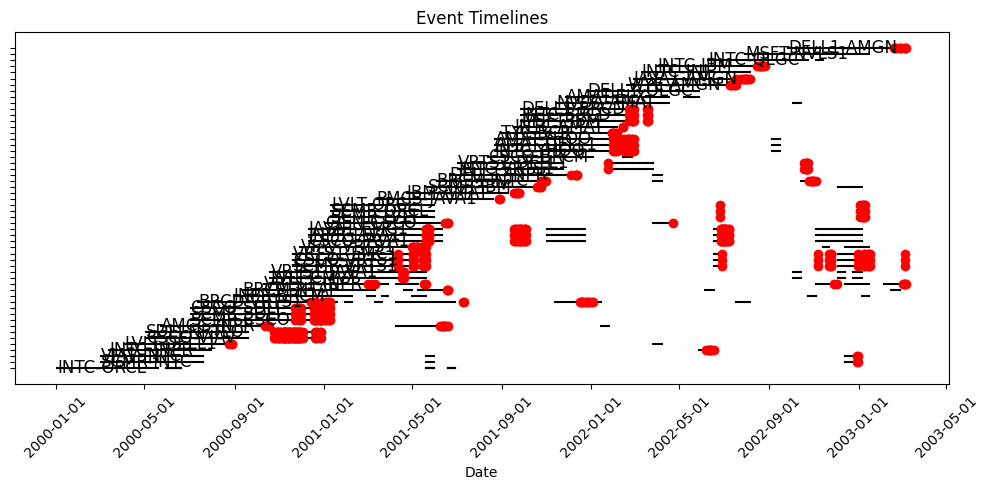

In [32]:
results = monitor_group_of_pairs(prices_with_market, pair_dict, 100)
print_overall_display(results)